<a href="https://colab.research.google.com/github/anshikaverma-me/Savings-Retention-Predictive-Modeling/blob/main/Savings_Retention_Predictive_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Intershala_Notebook/churn_prediction.csv')

In [6]:
pd.isnull(df).sum()

,0
customer_id,0
vintage,0
age,0
gender,525
dependents,2463
occupation,80
city,803
customer_nw_category,0
branch_code,0
days_since_last_transaction,3223


In [7]:
df['gender'].value_counts()

,count
gender,
Male,16548
Female,11309


In [8]:
#Convert Gender
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

df['gender'] = df['gender'].fillna(-1)

In [9]:
df['dependents'].value_counts()

,count
dependents,
0.0,21435
2.0,2150
1.0,1395
3.0,701
4.0,179
5.0,41
6.0,8
7.0,3
9.0,1


In [10]:
df['occupation'].value_counts()

,count
occupation,
self_employed,17476
salaried,6704
student,2058
retired,2024
company,40


In [11]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')

In [12]:
df['city'] = df['city'].fillna(1020)

In [13]:
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

In [14]:
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

In [15]:
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit',
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [16]:
df_df_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [17]:
y_all = df.churn
df = df.drop(['churn','customer_id','occupation'],axis = 1)

In [18]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [19]:
df_baseline = df[baseline_cols]

In [20]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y_all,test_size=1/3, random_state=11, stratify = y_all)

In [21]:
model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


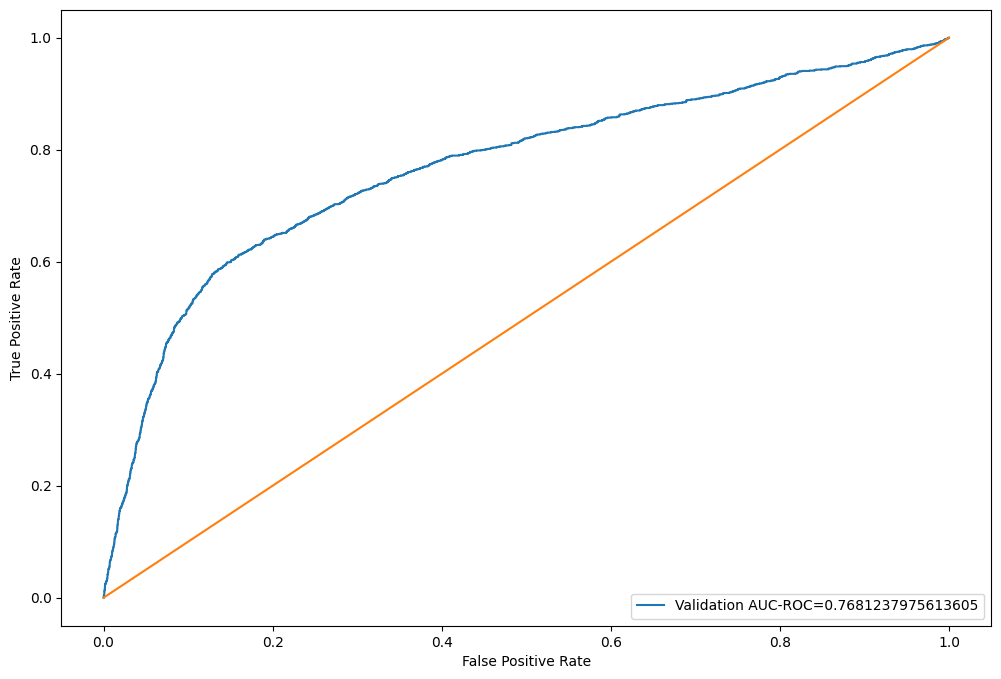

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred)
auc = roc_auc_score(ytest, pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc))
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [23]:
# Confusion Matrix
pred_val = model.predict(xtest)

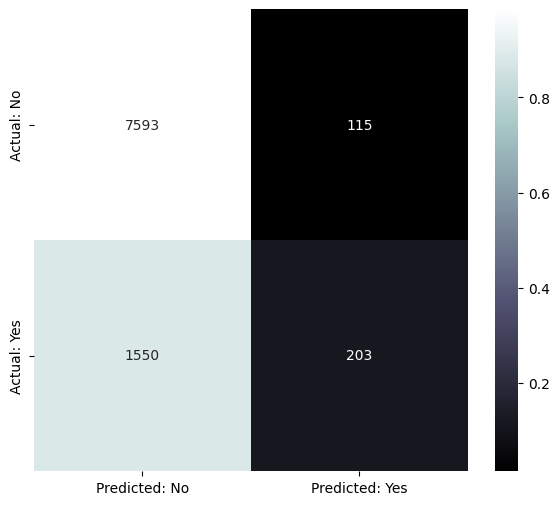

In [24]:
label_preds = pred_val

cm = confusion_matrix(ytest,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [25]:
# Recall Score
recall_score(ytest,pred_val)

0.11580148317170565

In [26]:
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]

    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = y_all.loc[df_index],y_all.loc[test_index]

        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []

        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)

        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))

         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [27]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score: 0.7644836090843695, Recall Score: 0.0751, Precision Score: 0.5766 

2 of kfold 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score: 0.7805820573425136, Recall Score: 0.0722, Precision Score: 0.6552 

3 of kfold 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score: 0.755325784138303, Recall Score: 0.1350, Precision Score: 0.6455 

4 of kfold 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score: 0.7582064809820148, Recall Score: 0.1169, Precision Score: 0.6508 

5 of kfold 5
ROC AUC Score: 0.7622577114607865, Recall Score: 0.1112, Precision Score: 0.5821 


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
all_feat_scores = cv_score(LogisticRegression())


1 of kfold 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score: 0.7331647312711952, Recall Score: 0.1103, Precision Score: 0.5066 

2 of kfold 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score: 0.7682234097215086, Recall Score: 0.1958, Precision Score: 0.6799 

3 of kfold 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score: 0.7393034111989685, Recall Score: 0.1683, Precision Score: 0.5728 

4 of kfold 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score: 0.7310815122291368, Recall Score: 0.1084, Precision Score: 0.6129 

5 of kfold 5
ROC AUC Score: 0.7590672158485403, Recall Score: 0.1778, Precision Score: 0.6052 


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rf_all_features = cv_score(RandomForestClassifier(n_estimators=100, max_depth=8))


1 of kfold 5
ROC AUC Score: 0.8200289795498921, Recall Score: 0.3603, Precision Score: 0.7274 

2 of kfold 5
ROC AUC Score: 0.842873291542493, Recall Score: 0.3565, Precision Score: 0.7716 

3 of kfold 5
ROC AUC Score: 0.835467868091097, Recall Score: 0.3546, Precision Score: 0.7460 

4 of kfold 5
ROC AUC Score: 0.8284642985185575, Recall Score: 0.3555, Precision Score: 0.7421 

5 of kfold 5
ROC AUC Score: 0.824461069375189, Recall Score: 0.3441, Precision Score: 0.7373 


In [31]:
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'random_forest': rf_all_features})

<Axes: >

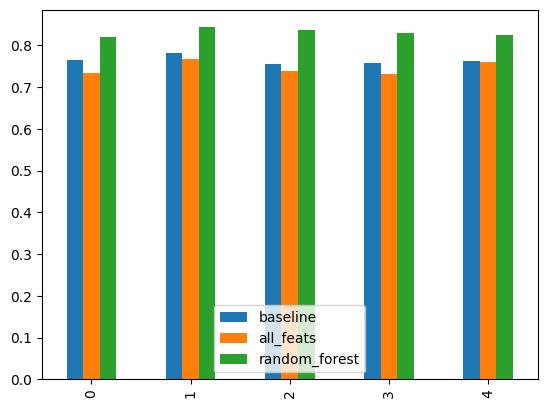

In [32]:
results_df.plot(y=["baseline", "all_feats", "random_forest"], kind="bar")